In [5]:
import requests
import folium
import numpy as np
import json
import pandas as pd
import plotly.express as px
import ipywidgets as ipw
import matplotlib.pyplot as plt
import seaborn as sns

# L'URL de l'API pour donné de compteur 
limit_datacount = 100 # télécharger 100 données mais ne pas saugarder localement 
offset_datacount = 0
dateEtHeure ='2023-12-24T23'
#api avec un filtre "order by" dans l'ordre décroissant de dates dans datacount
api_url_datacount = "https://data.metropole-rouen-normandie.fr/api/explore/v2.1/catalog/datasets/eco-counter-data/records?order_by=date%20DESC&limit=" + str(limit_datacount) +"&offset=" + str(offset_datacount)

#L'URL de l'API pour localisation des sites de comptage
api_url_localisation = "https://data.metropole-rouen-normandie.fr/api/explore/v2.1/catalog/datasets/eco-counter-sites/records?limit=29"

#L'URL de l'API pour télécharger toutes les données 
api_url_export = "https://data.metropole-rouen-normandie.fr/api/explore/v2.1/catalog/datasets/eco-counter-data/exports/json?lang=fr&timezone=Europe%2FBerlin"


# #local_data telecharge depuis serveur
local_data = pd.read_json("local_data.json")

update_data = [] # initialise update_data par une liste

dateEtHeure = local_data.iloc[0]['date'][:-12] # pour avoir la forme de variable dateEtHeure identique que celle declarée dessus

#L'URL de l'API pour la mise à jour de données (where date > dateEtHeure le plus récent indiqué dans local_data, order by date descendant, timezone Europe/Berlin)
api_url_update_data ="https://data.metropole-rouen-normandie.fr/api/explore/v2.1/catalog/datasets/eco-counter-data/records?where=date%3Edate'"+dateEtHeure+"%3A00%3A00%2B01%3A00'&order_by=date%20DESC&limit="+str(limit_datacount)+"&offset="+str(offset_datacount)+"&timezone=Europe%2FBerlin"


# Effectuer une requête GET pour obtenir les données
response_updateData = requests.get(api_url_update_data) # dictionnaire (indice total_count, indice results)
response_localisation = requests.get(api_url_localisation)

if (response_updateData.status_code != 200):
   
    print(f'Échec de la requête HTTP, code de statut {response_updateData.status_code}')

if (response_localisation.status_code != 200):
   
    print(f'Échec de la requête HTTP, code de statut {response_localisation.status_code}')



# Si la requête a réussi (code de statut HTTP 200), vous pouvez accéder aux données
data_localisation = response_localisation.json()

total_count = response_updateData.json()['total_count']

print(total_count)

if (total_count != 0) : # le nombre de données mises à jour 
    while (total_count >= 100) : # data limit is 100
        update_data.extend(requests.get(api_url_update_data).json()['results'])
        total_count -= 100
        offset_datacount +=  100
        api_url_update_data ="https://data.metropole-rouen-normandie.fr/api/explore/v2.1/catalog/datasets/eco-counter-data/records?where=date%3Edate'"+dateEtHeure+"%3A00%3A00%2B01%3A00'&order_by=date%20DESC&limit="+str(limit_datacount)+"&offset="+str(offset_datacount)+"&timezone=Europe%2FBerlin"

    limit_datacount = total_count
    api_url_update_data ="https://data.metropole-rouen-normandie.fr/api/explore/v2.1/catalog/datasets/eco-counter-data/records?where=date%3Edate'"+dateEtHeure+"%3A00%3A00%2B01%3A00'&order_by=date%20DESC&limit="+str(limit_datacount)+"&offset="+str(offset_datacount)+"&timezone=Europe%2FBerlin"
    update_data.extend(requests.get(api_url_update_data).json()['results'])
    list_local_data =local_data.to_dict(orient='records')
    update_data.extend(list_local_data)
    # Utilisez json.dump() pour sauvegarder le dictionnaire dans le fichier JSON

    with open('local_data.json', 'w') as fichier_json:
        json.dump(update_data, fichier_json)


# df_update_data =pd.DataFrame(update_data)
# df_combined = pd.concat([df_update_data,local_data])


# results_datacount = local_data['results']
#results_localisation = data_localisation['results']

# print("ID:", first_result['id'])
# print("Date:", first_result['date'])
# print("Counts:", first_result['counts'])
# print("Status:", first_result['status'])
# print("Name:", first_result['name'])
# print("User Type:", first_result['user_type'])
# print("Photo URL:", first_result['photourl'])
# print("Date_j:", first_result['date_j'])


# for i in range (len(results_localisation)):
    
#     lon = results_localisation[i]['coordinates']['lon']
#     lat = results_localisation[i]['coordinates']['lat']
#     if i==0:
#         map_center = [lat, lon]
#         mymap = folium.Map(location=map_center, zoom_start=15)
#     coordinates = [lat, lon]
   
#     # Dessiner un cercle proportionnel à l'intervalle
#     radius = np.sqrt(results_localisation[i]['interval'] / np.pi)   # Ajustez le facteur selon vos besoins
#     folium.CircleMarker(location=coordinates, radius=radius, color='blue', fill=True).add_to(mymap)
#     # Afficher la carte
# mymap.save('map.html')

0


In [6]:
df = pd.read_json('local_data.json')
df

,id,date,counts,status,name,user_type,photourl,date_j
0,300028856,2024-02-12T23:00:00+01:00,6,raw,Eco 21 - Rue General Leclerc ROUEN,Vélo,https://filer.eco-counter-tools.com/file/70/29...,2024-02-12
1,300033642,2024-02-12T23:00:00+01:00,20,raw,Eco 24 - Pont Corneille ROUEN,Vélo,https://filer.eco-counter-tools.com/file/67/18...,2024-02-12
2,300033641,2024-02-12T23:00:00+01:00,15,raw,Eco 23 - Pont Jeanne d'Arc ROUEN,Vélo,https://filer.eco-counter-tools.com/file/0e/da...,2024-02-12
3,300023463,2024-02-12T23:00:00+01:00,1,raw,Eco 13 - Route de Lyons La Forêt ROUEN,Vélo,https://filer.eco-counter-tools.com/file/b8/23...,2024-02-12
4,300035455,2024-02-12T23:00:00+01:00,2,raw,Eco 27 - Blvd de l'Europe ROUEN,Vélo,https://filer.eco-counter-tools.com/file/34/02...,2024-02-12
...,...,...,...,...,...,...,...,...
387809,100007117,2022-01-01T00:00:00+01:00,0,raw,Eco 09 - Avenue des Canadiens GRAND QUEVILLY,Vélo,https://filer.eco-counter-tools.com/file/31/3d...,2022-01-01
387810,100019265,2022-01-01T00:00:00+01:00,0,raw,Eco 04 - Zénith GRAND QUEVILLY,Vélo,https://filer.eco-counter-tools.com/file/f1/c9...,2022-01-01
387811,100007115,2022-01-01T00:00:00+01:00,0,raw,Eco 07 - Sente des Forrieres BOIS GUILLAUME,Vélo,https://filer.eco-counter-tools.com/file/d4/f7...,2022-01-01
387812,100048215,2022-01-01T00:00:00+01:00,2,raw,Eco 18 - Avenue Jacques Cartier ROUEN,Vélo,https://filer.eco-counter-tools.com/file/b8/26...,2022-01-01


['2024-02-12' '2024-02-11' '2024-02-10' '2024-02-09' '2024-02-08'
 '2024-02-07' '2024-02-06' '2024-02-05' '2024-02-04' '2024-02-03'
 '2024-02-02' '2024-02-01' '2024-01-31' '2024-01-30' '2024-01-29'
 '2024-01-28' '2024-01-27' '2024-01-26' '2024-01-25' '2024-01-24'
 '2024-01-23' '2024-01-22' '2024-01-21' '2024-01-20' '2024-01-19'
 '2024-01-18' '2024-01-17' '2024-01-16' '2024-01-15' '2024-01-14'
 '2024-01-13' '2024-01-12' '2024-01-11' '2024-01-10' '2024-01-09'
 '2024-01-08' '2024-01-07' '2024-01-06' '2024-01-05' '2024-01-04'
 '2024-01-03' '2024-01-02' '2024-01-01' '2023-12-31' '2023-12-30'
 '2023-12-29' '2023-12-28' '2023-12-27' '2023-12-26' '2023-12-25'
 '2023-12-24' '2023-12-23' '2023-12-22' '2023-12-21' '2023-12-20'
 '2023-12-19' '2023-12-18' '2023-12-17' '2023-12-16' '2023-12-15'
 '2023-12-14' '2023-12-13' '2023-12-12' '2023-12-11' '2023-12-10'
 '2023-12-09' '2023-12-08' '2023-12-07' '2023-12-06' '2023-12-05'
 '2023-12-04' '2023-12-03' '2023-12-02' '2023-12-01' '2023-11-30'
 '2023-11-

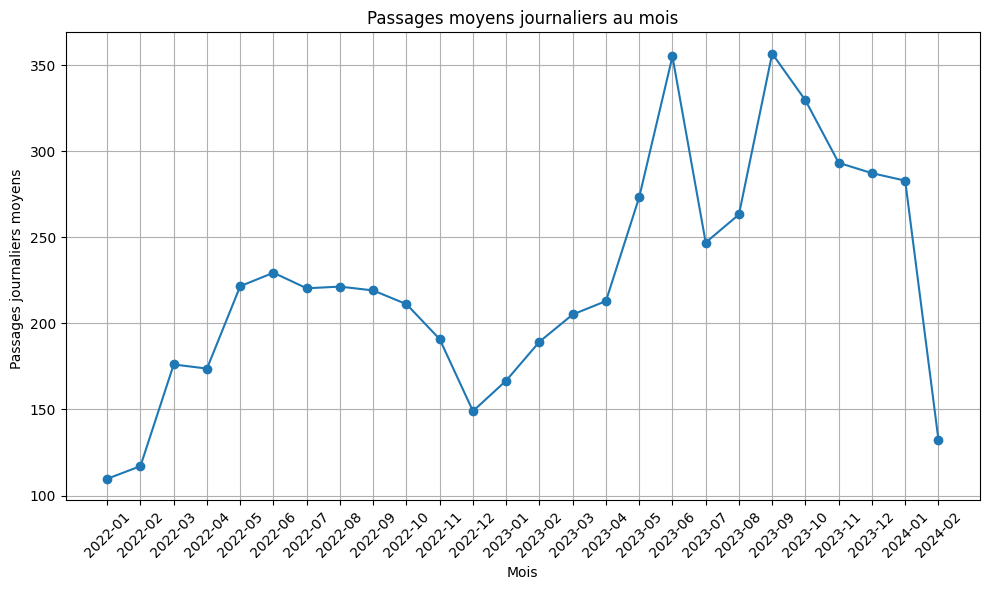

In [7]:
mois = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
an = ['2022', '2023', '2024']
date_jour = df['date_j'].unique()
print(date_jour)
# Convertir en datetime
df['date'] =  pd.to_datetime(df['date'], utc=True) # convertir depuis string en datetime
df['date_j'] = pd.to_datetime(df['date_j']) # convertir depuis string en datetime
df['month_year'] = df['date_j'].dt.to_period('M') # créer une colonne contenant le mois et l'année

# Créer une liste de tous les mois de 2022 à 2024
months = pd.period_range(start=df['month_year'].iloc[-1], end=df['month_year'].iloc[0], freq='M')

# Créer un DataFrame avec une colonne 'mois' contenant tous les mois et une colonne 'mean_count_per_day' initialisée à None
df_result = pd.DataFrame({'mois': months, 'mean_count_per_day': [None] * len(months)})

# Remplir la colonne 'mean_count_per_day' avec les valeurs moyennes correspondantes
for i, month_period in enumerate(months):
    # Calculer la valeur moyenne pour le mois donné
    total_counts = df[df['month_year'] == month_period]['counts'].sum()
    # passages moyennes journaliers par station
    mean_counts_per_day = total_counts / month_period.to_timestamp().days_in_month / len(df['name'].unique())
    # Assigner la valeur moyenne à la ligne correspondante dans le DataFrame résultant
    df_result.at[i, 'mean_count_per_day'] = mean_counts_per_day

# Afficher le résultat
plt.figure(figsize=(10, 6))
df_result['mois_str'] = df_result['mois'].astype(str)
plt.plot(df_result['mois_str'], df_result['mean_count_per_day'], marker='o', linestyle='-')

plt.title('Passages moyens journaliers au mois')
plt.xlabel('Mois')
plt.ylabel('Passages journaliers moyens ')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

           day      hour mean_count_per_day
0       Monday  00:00:00                  1
1      Tuesday  01:00:00                  0
2    Wednesday  02:00:00                  1
3     Thursday  03:00:00                  2
4       Friday  04:00:00                  3
..         ...       ...                ...
163  Wednesday  19:00:00                 13
164   Thursday  20:00:00                  9
165     Friday  21:00:00                  7
166   Saturday  22:00:00                  4
167     Sunday  23:00:00                  3

[168 rows x 3 columns]


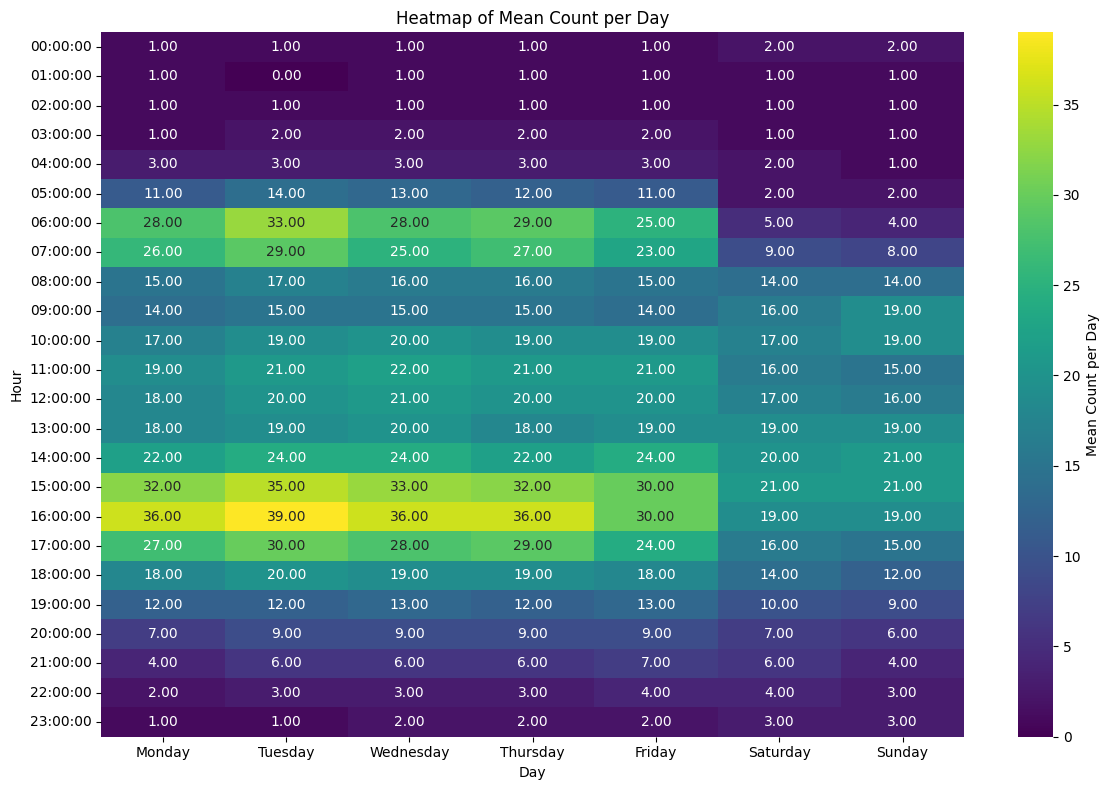

In [8]:
# Créer une liste de tous les heures dans une journée
heures = pd.period_range(start='00:00', end='23:00', freq='h')
heures_only = [str(heure.strftime('%H:%M:%S')) for heure in heures]

# Créer une liste de tous les jours de la semaine
days_in_a_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Créer un DataFrame avec une colonne 'day' contenant les jours, une colonne 'hour' contenant les heures, 
# et une colonne 'mean_count_per_day' initialisée à None
df_result = pd.DataFrame({'day': days_in_a_week * len(heures_only), # 24 heures x 7 jours
                          'hour': heures_only * len(days_in_a_week), 
                          'mean_count_per_day': [None] * len(days_in_a_week) * len(heures_only)})

df['day_name'] = df['date_j'].dt.day_name() # convertir depuis date en day_name (Monday, Tuesday)

# Extraire uniquement l'heure de la colonne 'date' et stocker le résultat dans une nouvelle colonne 'heure' dans df
df['heure'] = df['date'].dt.strftime('%H:%M:%S')

# Remplir la colonne 'mean_count_per_day' de df_result avec les valeurs moyennes appropriées
for hour in heures_only:
    for day_name in days_in_a_week:
        # créer un autre datafame qui contient toutes les données correspondantes au jour et à l'heure donnés
        filtered_data = df[(df['day_name'] == day_name) & (df['heure'] == hour)]
        # Calculer la moyenne des valeurs de la colonne 'counts' pour ces données filtrées
        mean_count = filtered_data['counts'].mean()
        # Assigner la valeur moyenne à la date et heure correspondantes dans le DataFrame résultant
        df_result.loc[(df_result['day'] == day_name) & (df_result['hour'] == hour), 'mean_count_per_day'] = round(mean_count)

print(df_result)

# Convertir les colonnes 'day' et 'hour' en variables catégorielles avec un ordre spécifique
df_result['day'] = pd.Categorical(df_result['day'], categories=days_in_a_week, ordered=True)
df_result['hour'] = pd.Categorical(df_result['hour'], categories=heures_only, ordered=True)
df_result['mean_count_per_day'] = pd.to_numeric(df_result['mean_count_per_day'], errors='coerce')

# Pivoter les données pour avoir les jours comme index, les heures comme colonnes et les valeurs de 'mean_count_per_day' comme valeurs
heatmap_data = df_result.pivot(index='hour', columns='day', values='mean_count_per_day')

# Tracer le heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt=".2f", cbar_kws={'label': 'Mean Count per Day'})
plt.title('Heatmap of Mean Count per Day')
plt.xlabel('Day')
plt.ylabel('Hour')
plt.tight_layout()
plt.show()

  jours_de_semaine moy_journaliere
0           Monday             241
1          Tuesday             266
2        Wednesday             259
3         Thursday             256
4           Friday             243
5         Saturday             176
6           Sunday             168


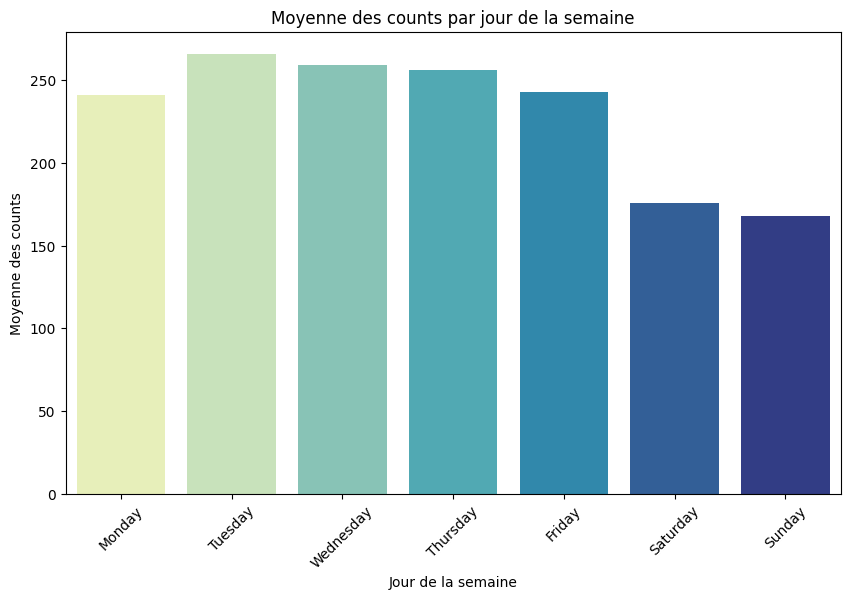

In [9]:
# Créer le DataFrame df_result_moy_journaliere
df_result_moy_journaliere = pd.DataFrame({'jours_de_semaine': days_in_a_week, 'moy_journaliere': [None] * len(days_in_a_week)})

# Pour chaque jour de la semaine
for day_name in days_in_a_week:
    # Filtrer les données pour le jour donné
    filtered_data = df[df['day_name'] == day_name]
    unique_days = len(filtered_data['date_j'].unique()) # enlever les heures et garder que la date
    # Calculer la moyenne des valeurs de la colonne 'counts' pour ces données filtrées
    mean_count = filtered_data['counts'].sum() / unique_days/ len(df['name'].unique())  # somme de tous les passages pour chaque date/ nombre de chaque date/ nombre de stations
    # Assigner la valeur moyenne à la date correspondante dans le DataFrame résultant
    df_result_moy_journaliere.loc[df_result_moy_journaliere['jours_de_semaine'] == day_name, 'moy_journaliere'] = round(mean_count)

print(df_result_moy_journaliere)

# Tracer un histogramme de la moyenne journalière
plt.figure(figsize=(10, 6))
sns.barplot(data=df_result_moy_journaliere, x='jours_de_semaine', y='moy_journaliere', hue='jours_de_semaine', palette='YlGnBu', dodge=False)
plt.title('Moyenne des counts par jour de la semaine')
plt.xlabel('Jour de la semaine')
plt.ylabel('Moyenne des counts')
plt.xticks(rotation=45)  # Rotation des étiquettes d'axe x pour une meilleure lisibilité
plt.show()


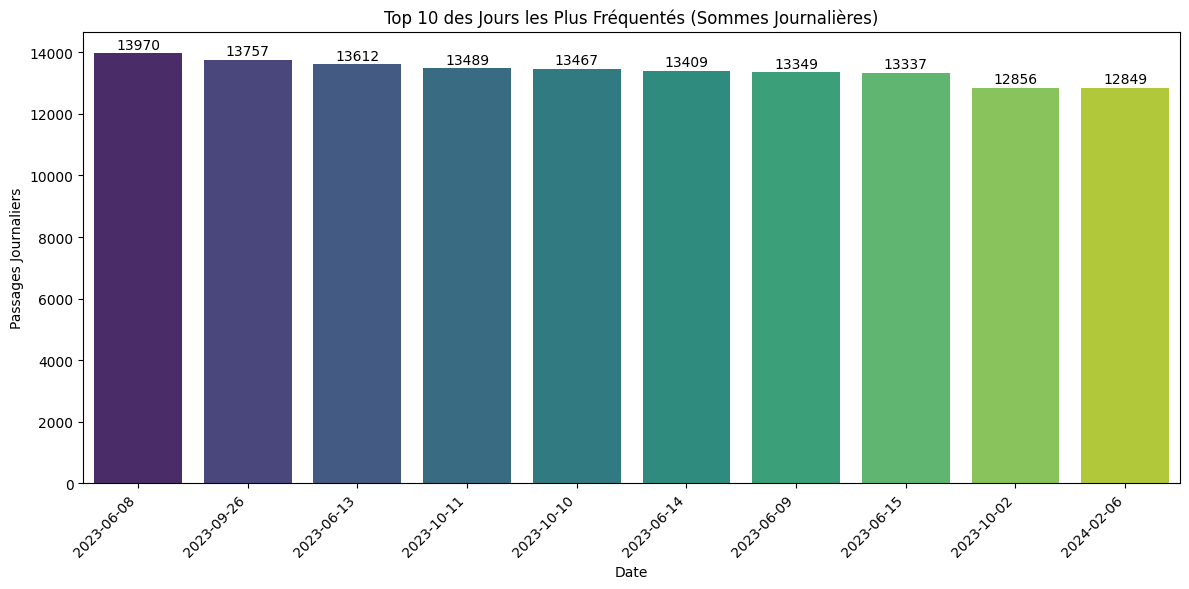

In [10]:
# Grouper par date_j et calculer la somme des passages pour chaque jour
daily_counts = df.groupby('date_j')['counts'].sum().reset_index()

# Trier par ordre décroissant pour obtenir les jours les plus fréquentés en premier
top_10_days = daily_counts.sort_values(by='counts', ascending=False).head(10)

# Tracer l'histogramme
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(x='date_j', y='counts', hue='date_j', data=top_10_days, palette='viridis', dodge=False, legend=False)
plt.title('Top 10 des Jours les Plus Fréquentés (Sommes Journalières)')
plt.xlabel('Date')
plt.ylabel('Passages Journaliers')
plt.xticks(rotation=45, ha='right')  # Rotation des étiquettes d'axe x pour une meilleure lisibilité
plt.tight_layout()

# Afficher le nombre de passages sur chaque bar
for idx, value in enumerate(top_10_days['counts']):
    bar_plot.text(idx, value + 50, str(value), ha='center', va='bottom')

plt.show()

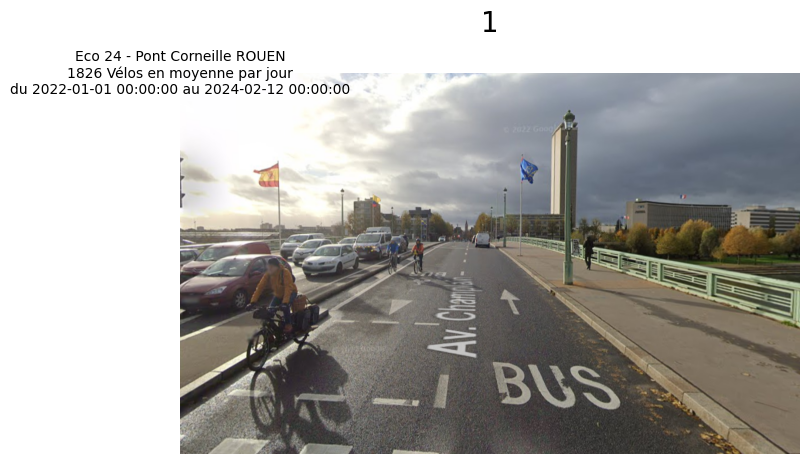

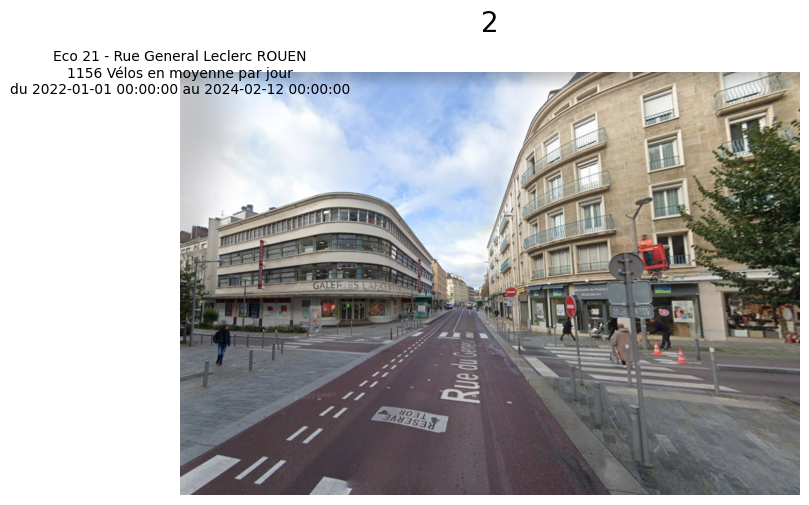

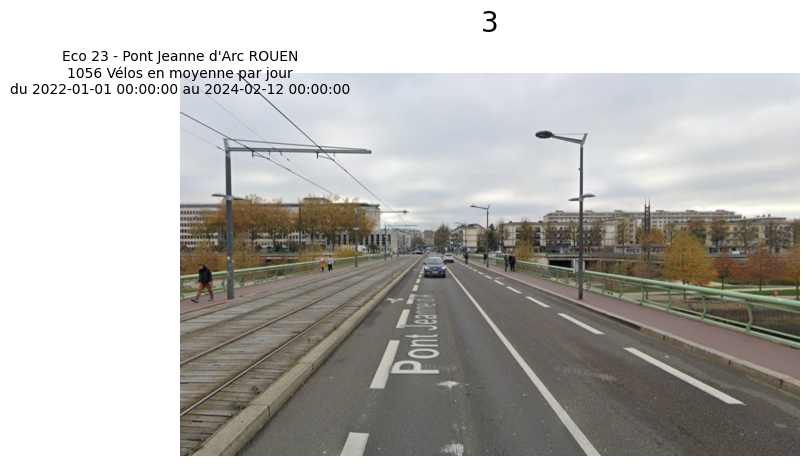

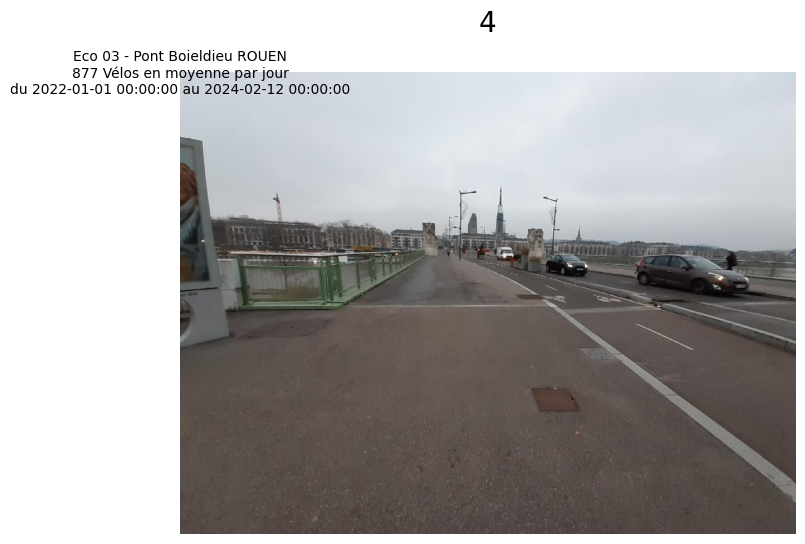

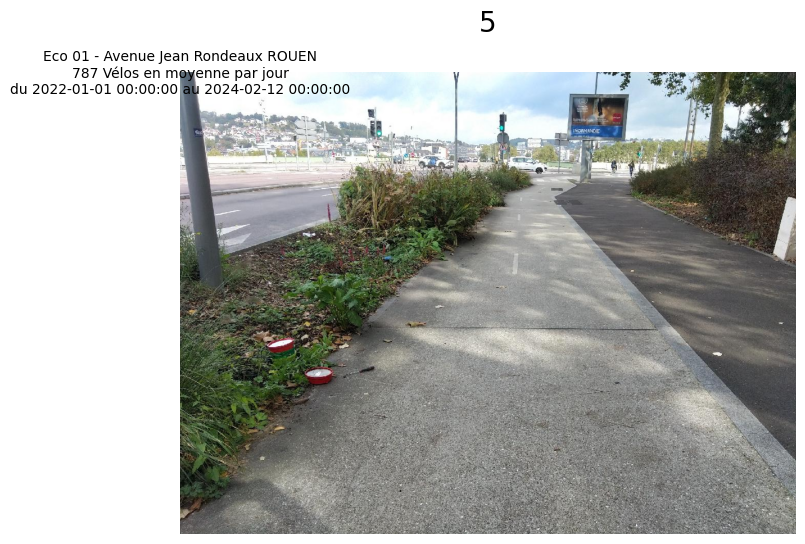

In [12]:
from PIL import Image
from io import BytesIO
# Calculer le nombre total moyen de passages par jour pour chaque station
station_stats = df.groupby(['id', 'name', 'photourl']).agg(total_passages=('counts', 'sum'), total_days=('date_j', 'nunique')).reset_index()
station_stats['average_passages_per_day'] = station_stats['total_passages'] / station_stats['total_days']

# Classer les stations par le nombre total moyen de passages par jour de manière décroissante
top_stations = station_stats.sort_values(by='average_passages_per_day', ascending=False).head(5)

# Afficher les informations pour les cinq meilleures stations avec les images correspondantes depuis les liens dans 'photourl'
for i, (index, station) in enumerate(top_stations.iterrows(), 1):
    # Charger l'image depuis le lien correspondant à la station
    response = requests.get(station['photourl'])
    img = Image.open(BytesIO(response.content))

    # Afficher le numéro de la station et son image
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.title(f'{i}\n', loc='center', fontsize=20)

    # Afficher les informations de la station
    plt.text(0.5, 0.5, f'{station["name"]}\n'
                        f'{int(station["average_passages_per_day"])} Vélos en moyenne par jour\n'
                        f'du {df["date_j"].min()} au {df["date_j"].max()}',
             ha='center', va='center', fontsize=10)

    # Masquer les axes
    plt.axis('off')

    # Afficher l'image
    plt.show()